# __1. Thư viện__

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install underthesea
# !pip install pyvi
# !pip install import-ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

import string
import re
import nltk
import seaborn as sns
# nltk.download('twitter_samples')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')
from underthesea import word_tokenize, pos_tag
from pyvi import ViTokenizer, ViPosTagger

%matplotlib inline

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# __2. Tiền xử lý dữ liệu__

In [2]:
def preprocess_text(dataset, col_name, teencode_dict_path):
    # 1. Convert text to lowercase
    dataset[col_name] = dataset[col_name].str.lower()

    # 2. Load teencode dictionary
    teencode_dict = dict(pd.read_csv(teencode_dict_path, delimiter='\t').values)

    # 3. Handle teencode
    def handle_teencode(text, teencode_dict):
        return ' '.join([teencode_dict[word] if word in teencode_dict else word for word in text.split(' ')])

    dataset[col_name] = dataset[col_name].apply(lambda x: handle_teencode(str(x), teencode_dict))

    # 4. Standardize stretched words (e.g., "heeeellooo" -> "helo")
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'(\D)\1+', r'\1', str(x)))

    # 5. Remove words with length greater than 7
    def remove_words_over_length(text, length):
        return ' '.join([word for word in text.split(' ') if len(word) <= length])

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_words_over_length(str(x), 7))

    # 6. Remove white spaces, \n, \t, \r, \v
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'\s+', ' ', str(x).strip()))

    # 7. Remove numbers and special characters
    def remove_numbers_and_special_characters(text):
        text = re.sub(r'[' + string.punctuation + ']', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_numbers_and_special_characters(str(x)))

    #8. Drop NA data
    dataset.dropna(subset=[col_name], inplace=True)

    # 9. Tokenize text using word_tokenize from underthesea
    dataset['word_tokenize'] = dataset[col_name].apply(lambda x: word_tokenize(str(x), format='text'))

    return dataset

### ___2.1. Tiền xử lý file full___

In [5]:
file_path = r'train_sentiment_vie.xlsx'
df = pd.read_excel(file_path)
print(df.head())

                                    content_comments  \
0  Thay đổi cmt tăng 1 size. Hãy làm như bạn muốn...   
1  quần dày\nMỗi lần size nhỏ nhắn tin shop đổi s...   
2  Đã nhận được hàng...shop đóng gói nhanh...đúng...   
3  Đã nhận được hàng...shop đóng gói nhanh...đúng...   
4  Hình ảnh nhận xu và quan đơn giản thôi nhé...\...   

                                         comment_eng  sentiment  
0  Change the cmt to increase 1 size. Please do a...          0  
1  thick pants\nEvery time the size is small, mes...          0  
2  Received the goods...shop packaged quickly...r...          1  
3  Received the goods...shop packaged quickly...r...          1  
4  The picture of receipt of coin and quan is sim...          0  


In [6]:
df = preprocess_text(df, 'content_comments', 'teencode.txt')

In [7]:
# prompt: Kiểm tra trong DF có giá trị NA không ?

print(df.isnull().sum())

content_comments    0
comment_eng         0
sentiment           0
word_tokenize       0
dtype: int64


In [9]:

# Save the preprocessed data to a new Excel file
output_file_path = '/content/drive/MyDrive/Colab Notebooks/Code/NopThay/preprocessed_data.xlsx'  # Specify the desired output path
df.to_excel(output_file_path, index=False)  # Save to Excel without the index column

print(f"Preprocessed data saved to: {output_file_path}")

### ___2.2. Tiền xử lý file split___

In [4]:
file_path1 = 'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\train_split_sentiment_vie.xlsx'
df1 = pd.read_excel(file_path1)
df1.head()

,Unnamed: 0,comment,sentiment_manual
0,3.0,thun dày,1
1,4.0,túi có khóa kéo,1
2,NaN,Mỗi lần size nhỏ nhắn shop đổi size to hơn như...,0
3,8.0,quần dày\n,1
4,9.0,Đã nhận được hàng,1


In [5]:
df1 = preprocess_text(df1, 'comment',  'teencode.txt')

In [6]:
# Save the preprocessed data to a new Excel file
output_file_path1 = 'preprocessed_data1.xlsx'  # Specify the desired output path
df1.to_excel(output_file_path1, index=False)  # Save to Excel without the index column

print(f"Preprocessed data saved to: {output_file_path1}")

Preprocessed data saved to: preprocessed_data1.xlsx


### ___2.3. Tiền xử lý file test___

In [14]:
file_path2 = 'testset.xlsx'
df2 = pd.read_excel(file_path2)
df2.head()

,Unnamed: 0,orderid,itemid,itemname,cmtid,ctime,rating,userid,shopid,comment,...,image_data,key_media,is_super_review,region,original_item_info,show_super_review_tag,super_review_status,template_tags,ItemRatingReply,display_variation_filter
0,0,92941960095687,11305172432,Áo sơ mi,6980041307,1640013969,1,393720644,259681663,Áo sơ mi trắng này chất lụa mặc vào mát lạnh l...,...,[{'image_id': 'acdfe3c4e513bf379e1be34828eb69a...,"{'key_media_code': 1, 'key_media_id': 'vn_091a...",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
1,1,88914825374056,11305172432,Áo sơ mi,6443720741,1635589554,1,41678132,259681663,Chất lượng sản phẩm trên cả hy vọng. \nÁo đườn...,...,[{'image_id': '194cf53082a08ce28090c3e0c75f438...,"{'key_media_code': 1, 'key_media_id': 'vn_7c48...",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
2,2,101639107204879,11305172432,Áo sơ mi,7911794551,1648665082,1,59135900,259681663,Đây là một trong những shop menswear cute nhất...,...,[{'image_id': '0d503deada278926fd8e443356d588a...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN
3,3,151066957232306,11305172432,Áo sơ mi,12944626201,1697820759,1,958994801,259681663,Đúng với mô tả:đúng\nChất liệu:vải\nMàu sắc:tr...,...,[{'image_id': 'vn-11134103-7r98o-ln36f5i7e2432...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,"['Đúng với mô tả', 'Chất liệu', 'Màu sắc']",NaN,NaN
4,4,89477296313770,11305172432,Áo sơ mi,6504669981,1636185616,1,5474768,259681663,Camera mình hơi xấu nhưng mà lần đầu tiên mua ...,...,[{'image_id': '7305922d12a767bd702a0ec1ace0dff...,"{'key_media_code': 0, 'key_media_id': ''}",False,VN,"{'itemid': 11305172432, 'shopid': 259681663, '...",False,0,NaN,NaN,NaN


In [15]:
df2 = preprocess_text(df2, 'comment',  'teencode.txt')

In [ ]:
# Save the preprocessed data to a new Excel file
output_file_path2 = '/content/drive/MyDrive/Colab Notebooks/Code/NopThay/preprocessed_test.xlsx'  # Specify the desired output path
df2.to_excel(output_file_path2, index=False)  # Save to Excel without the index column

print(f"Preprocessed data saved to: {output_file_path2}")

Preprocessed data saved to: /content/drive/MyDrive/Colab Notebooks/Code/NopThay/preprocessed_test.xlsx


# __3. Phân tích khám phá - EDA__

In [16]:
# prompt: Đếm coi bộ dữ liệu có bao nhiều dòng

print(len(df))
print(len(df1))

1040
8485


In [38]:
# prompt: Viết đoạn code thống kê có bao nhiêu comment tiêu cực (0) comment tích cực (1) ở cột sentiment

negative_comments = df[df['sentiment'] == 0].shape[0]
positive_comments = df[df['sentiment'] == 1].shape[0]

print(f"Number of negative comments: {negative_comments}")
print(f"Number of positive comments: {positive_comments}")

Number of negative comments: 479
Number of positive comments: 561


In [52]:
# prompt: Viết đoạn code thống kê có bao nhiêu comment tiêu cực (0) comment tích cực (1) ở cột sentiment

negative_comments_split = df1[df1['sentiment_manual'] == 0].shape[0]
positive_comments_split = df1[df1['sentiment_manual'] == 1].shape[0]

print(f"Number of negative comments: {negative_comments_split}")
print(f"Number of positive comments: {positive_comments_split}")

Number of negative comments: 2191
Number of positive comments: 6294


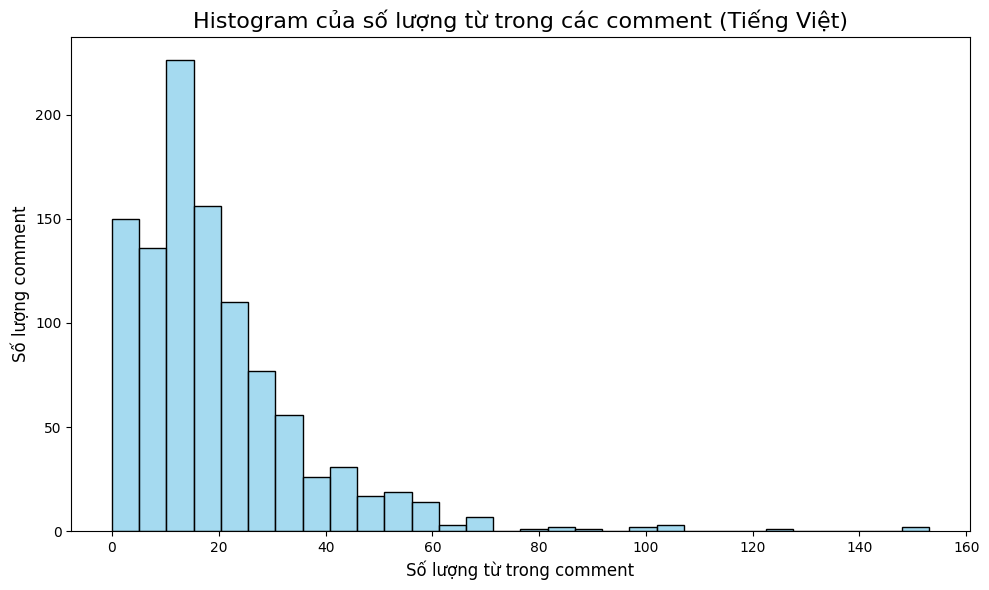

In [32]:
from underthesea import word_tokenize

# Tách từ trong mỗi comment (dùng underthesea cho tiếng Việt)
df['word_count'] = df['content_comments'].apply(lambda x: len(word_tokenize(x)))

# Vẽ histogram cho số lượng từ trong các comment
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], kde=False, color='skyblue', bins=30)

# Thêm tiêu đề và nhãn
plt.title('Histogram của số lượng từ trong các comment (Tiếng Việt)', fontsize=16)
plt.xlabel('Số lượng từ trong comment', fontsize=12)
plt.ylabel('Số lượng comment', fontsize=12)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

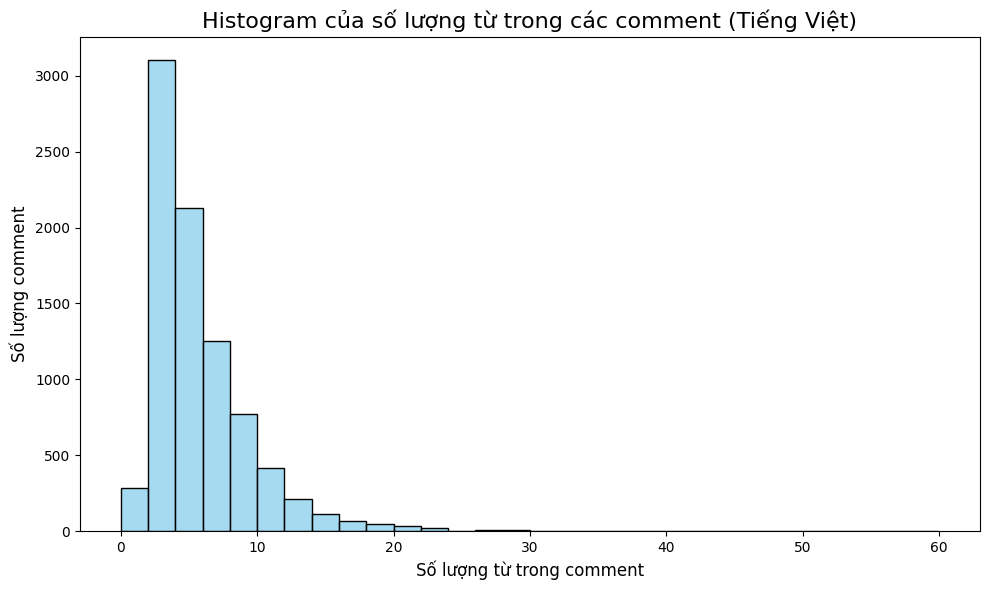

In [36]:
from underthesea import word_tokenize

# Tách từ trong mỗi comment (dùng underthesea cho tiếng Việt)
df1['word_count'] = df1['comment'].apply(lambda x: len(word_tokenize(x)))

# Vẽ histogram cho số lượng từ trong các comment
plt.figure(figsize=(10, 6))
sns.histplot(df1['word_count'], kde=False, color='skyblue', bins=30)

# Thêm tiêu đề và nhãn
plt.title('Histogram của số lượng từ trong các comment (Tiếng Việt)', fontsize=16)
plt.xlabel('Số lượng từ trong comment', fontsize=12)
plt.ylabel('Số lượng comment', fontsize=12)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [44]:
# prompt: Viết đoạn code thống kê có bao nhiêu comment tiêu cực (0) comment tích cực (1) ở cột sentiment

negative_comments = df[df['sentiment'] == 0]['word_tokenize']
positive_comments = df[df['sentiment'] == 1]['word_tokenize']

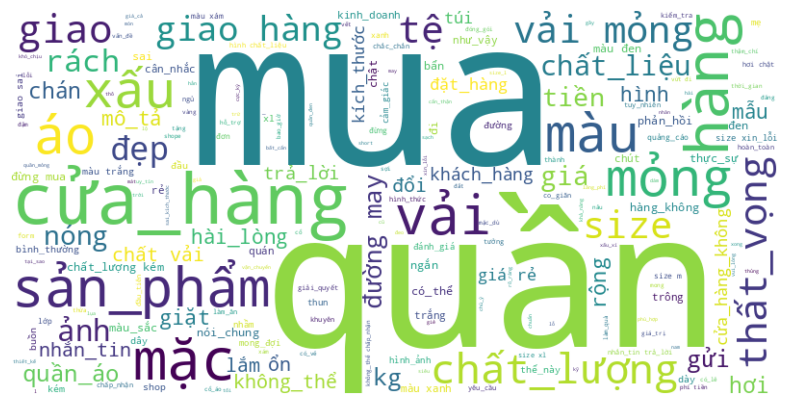

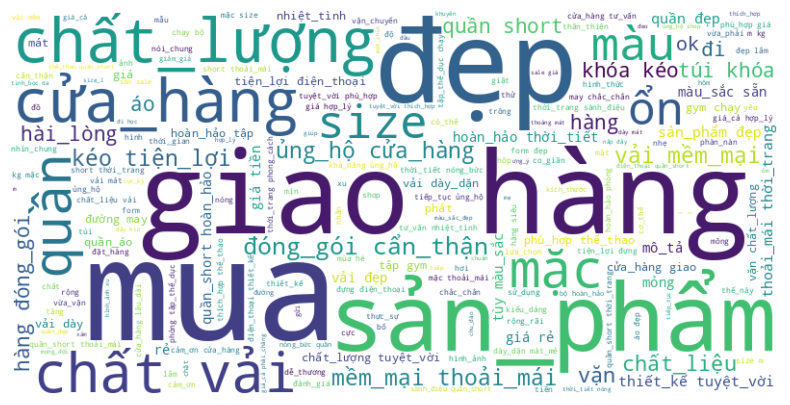

In [45]:
from wordcloud import WordCloud

# Hàm tải stopwords
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()
    return set(stopwords)

# Hàm xử lý văn bản và loại bỏ stopwords
def remove_stopwords(text, stopwords):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in stopwords and word not in string.punctuation]
    return ' '.join(cleaned_tokens)

# Hàm vẽ WordCloud
def plot_wordcloud_from_comments(comments, stopwords):
    # Kết hợp tất cả các bình luận vào một văn bản duy nhất
    all_comments = ' '.join(comments)

    # Xử lý văn bản để loại bỏ stopwords
    cleaned_text = remove_stopwords(all_comments, stopwords)

    # Tạo wordcloud từ văn bản đã xử lý
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cleaned_text)

    # Vẽ wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Ví dụ sử dụng:
STOPWORDS_FILE = "vietnamese_stopwords.txt"  # Đảm bảo bạn có file này
stopwords_vietnamese = load_stopwords(STOPWORDS_FILE)

# Vẽ WordCloud cho các bình luận tiêu cực
plot_wordcloud_from_comments(negative_comments, stopwords_vietnamese)
plot_wordcloud_from_comments(positive_comments, stopwords_vietnamese)

In [48]:
# prompt: Viết đoạn code thống kê có bao nhiêu comment tiêu cực (0) comment tích cực (1) ở cột sentiment

negative_comments = df1[df1['sentiment_manual'] == 0]['word_tokenize']
positive_comments = df1[df1['sentiment_manual'] == 1]['word_tokenize']

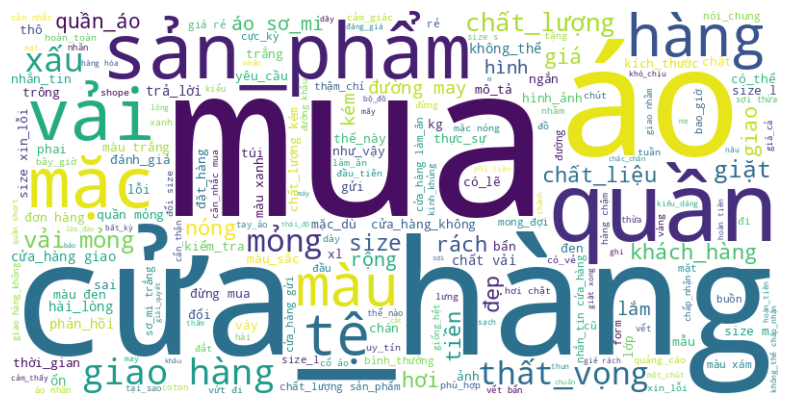

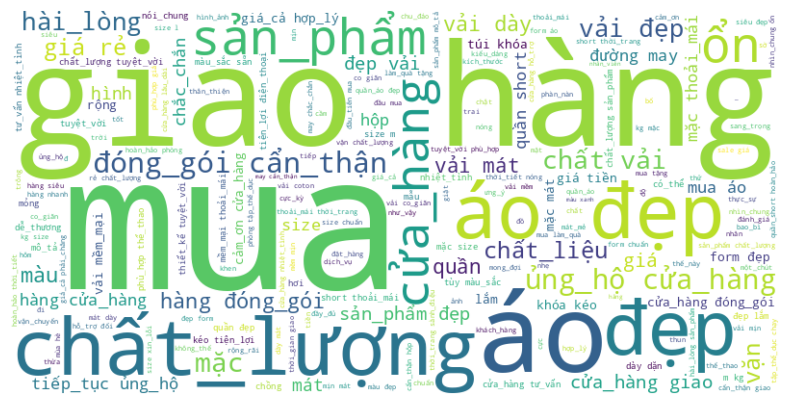

In [49]:
plot_wordcloud_from_comments(negative_comments, stopwords_vietnamese)
plot_wordcloud_from_comments(positive_comments, stopwords_vietnamese)